In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from IPython.display import clear_output

import pickle

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
def smooth_and_downsample(data, window_size=10, num_points=1000):
    # Apply moving average
    smoothed_data = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    
    # Downsample the smoothed data
    if len(smoothed_data) <= num_points:
        return smoothed_data
    indices = np.linspace(0, len(smoothed_data) - 1, num_points, dtype=int)
    res = []
    for i in indices:
        res.append(np.median(smoothed_data[i:i+window_size]))
    return res

In [23]:
import torch
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset
from collections import defaultdict
import os

class TrajectoryDataset(Dataset):
    def __init__(self, paths: list[str]):
        super(TrajectoryDataset, self).__init__()
        
        # paths = [
        #     'data/experts/Expert1_random=0.0_2024-12-31_21-59',
        #     'data/experts/Expert1_random=0.1_2024-12-31_22-03',
        #     'data/experts/Expert1_random=0.2_2024-12-31_22-04'
        # ]

        data = defaultdict(list)
        for folder in paths:
            for path in tqdm(os.listdir(folder)):
                loaded_data = np.load(f'{folder}/{path}')
                loaded_data.allow_pickle = True
                restored_dict = {key: loaded_data[key] for key in loaded_data}
                for key in restored_dict:
                    data[key].append(restored_dict[key])
                    
        for key in data:
            data[key] = np.concat(data[key])
        
        self.data = data
        
        self.continuous_vars = ['attachment_time_left', 'center_path', 'center_path_distance', 'distance_down_track', 'energy', 'front', 'items_position', 'karts_position', 'max_steer_angle', 'paths_distance', 'paths_end', 'paths_start', 'paths_width', 'shield_time', 'skeed_factor', 'velocity']
        self.discrete_vars = ['attachment', 'items_type', 'jumping', 'powerup']
        
        # self.means, self.stds = {}, {}
        # for key in self.continuous_vars:
        #     self.means[key] = self.data[key].mean(axis=0)
        #     self.stds[key] = self.data[key].std(axis=0)
        #     self.stds[key][self.stds[key] == 0] = 1.0
        
        # self.mean = torch.tensor(continuous_data.mean(axis=0), dtype=torch.float32)
        # self.std = torch.tensor(continuous_data.std(axis=0), dtype=torch.float32)        
        # self.std[self.std == 0] = 1.0

    def __len__(self):
        return len(self.data['actions'])
    
    def __getitem__(self, index):
        action = self.data['actions'][index]
        
        continuous_state = []
        for key in self.continuous_vars:
            value = self.data[key][index]
            if key in ['items_position', 'paths_end', 'paths_start', 'paths_width']:
                # normalized_value = (value[:5] - self.means[key][:5]) / self.stds[key][:5]
                normalized_value = value[:5]
            else:    
                # normalized_value = (value - self.means[key]) / self.stds[key]
                normalized_value = value
                
            continuous_state.append(normalized_value.flatten())

        continuous_state = np.concatenate(continuous_state)

        state = continuous_state

        state = torch.tensor(state, dtype=torch.float32)
        action = torch.tensor(action, dtype=torch.long)
        
        return state, action

        
    
    
dataset = TrajectoryDataset(paths=[
    'data/experts/Expert3_2025-01-26_14-59',
])

train_size = int(0.9 * len(dataset))  
test_size = len(dataset) - train_size 
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(len(train_dataset))

100%|██████████| 100/100 [00:05<00:00, 17.39it/s]


900000


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MLPWithMultipleHeads(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dims):
        super(MLPWithMultipleHeads, self).__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.heads = nn.ModuleList([
            # nn.Linear(hidden_dim, out_dim)
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, out_dim),
            )
            for out_dim in output_dims])
        
        
        self.critic = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, x):
        shared_output = self.shared_layers(x)
        action_logits = [head(shared_output) for head in self.heads]
        return action_logits

In [9]:
input_dim = 121
hidden_dim = 512

output_dims = [5, 2, 2, 2, 2, 2, 7]

model = MLPWithMultipleHeads(input_dim, hidden_dim, output_dims).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

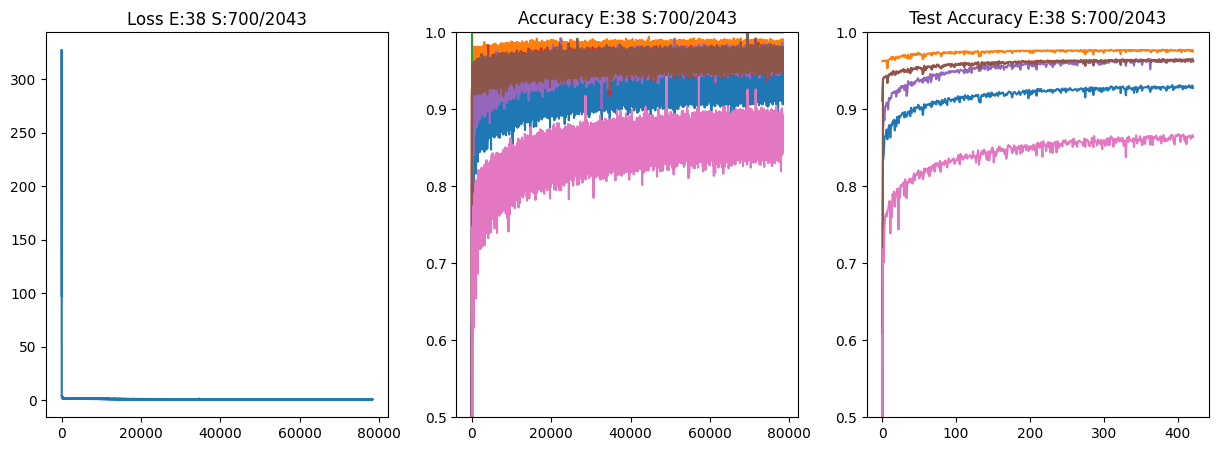

Epoch:   4%|▍         | 38/1000 [1:09:15<29:13:11, 109.35s/it]


KeyboardInterrupt: 

In [10]:
losses = []
accs = []
test_accs = []

for epoch in tqdm(range(1000), desc='Epoch'):
    for step, (obs, action) in enumerate(train_loader):
        
        obs, action = obs.to(device), action.to(device)
        
        pred_action = model(obs)
            
        loss = 0
        acc = []
        count = 0
        for i in range(len(pred_action)):
        # for i in range(1, 2):
            loss += criterion(pred_action[i], action[:, i])
            acc.append((pred_action[i].argmax(dim=1) == action[:, i]).sum().item() / len(action[:, i]))
            count += 1
        # acc = np.prod(acc)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        accs.append(acc)
        losses.append(loss.item())
        
        
        if step % 200 == 0:
            collect_test_accs = []
            for step, (obs, action) in enumerate(test_loader):  
                obs, action = obs.to(device), action.to(device)
                with torch.no_grad():
                    pred_action = model(obs)  
                acc = []
                for i in range(len(pred_action)):
                    acc.append((pred_action[i].argmax(dim=1) == action[:, i]).sum().item() / len(action[:, i]))
                collect_test_accs.append(acc)
            test_accs.append(np.array(collect_test_accs).mean(axis=0))
            
        
        if step % 100 == 0:
            clear_output(True)
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            axs[0].plot(losses)
            axs[0].set_title(f"Loss E:{epoch} S:{step}/{len(train_loader)}")
            axs[1].plot(accs)
            axs[1].set_title(f"Accuracy E:{epoch} S:{step}/{len(train_loader)}") 
            axs[1].set_ylim([0.5, 1])
            axs[2].plot(test_accs)
            axs[2].set_title(f"Test Accuracy E:{epoch} S:{step}/{len(train_loader)}")
            axs[2].set_ylim([0.5, 1])
            plt.show()
            
        # break
    # break

In [12]:
torch.save(model.state_dict(), 'models/behavioral_cloning.pt')